In [37]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import copy

def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------
input_size = 32 * 32 * 3
layer_config= [512, 256]
num_classes = 10
num_epochs = 1
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 0.99
reg=0#0.001
num_training= 49000
num_validation =1000
fine_tune = False
pretrained=True

data_aug_transforms = [transforms.RandomHorizontalFlip(p=0.5)]#, transforms.RandomGrayscale(p=0.05)]
#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
# Q1,
norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=norm_transform
                                          )
#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Using device: cpu
Files already downloaded and verified


In [38]:
class VggModel(nn.Module):
    def __init__(self, n_class, fine_tune, pretrained=True):
        super(VggModel, self).__init__()
        #################################################################################
        # TODO: Build the classification network described in Q4 using the              #
        # models.vgg11_bn network from torchvision model zoo as the feature extraction  #
        # layers and two linear layers on top for classification. You can load the      #
        # pretrained ImageNet weights based on the pretrained flag. You can enable and  #
        # disable training the feature extraction layers based on the fine_tune flag.   #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        vgg = models.vgg11_bn(pretrained)
        # print("\nOriginal VGG model:\n")
        # print(vgg)
        c=0
        for name,param in vgg.named_parameters():
            if param.requires_grad == True:
#                 print("\t",name)
                c+=1
        print("total learnable params in orignal model: "+str(c))
        
        set_parameter_requires_grad(vgg,not fine_tune)
        del vgg.avgpool
        del vgg.classifier
        vgg.classifier = nn.Sequential(torch.nn.Linear(512,512,True),torch.nn.ReLU(True),torch.nn.Linear(512,num_classes,True))

        print("\n\nUpdated Model\n")
        print(vgg)
        d=0
        c=0
        print('\nParams that are to be learnt when fine_tine is set to {}\n'.format(fine_tune))  
        for name,param in vgg.named_parameters():
            if param.requires_grad == True:
                print("\t",name)
                c+=1
            d+=1
        print('\nTotal params : {}\nTotal learnable params when fine_tine is set to {} : {}\n \n'.format(d,fine_tune,c))  
        self.model=vgg
        self.features=vgg.features
        self.classifier=vgg.classifier
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        x = self.features(x)
        x = torch.flatten(x, 1)
        out = self.classifier(x)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)***** 
        return out  
    

In [41]:


#################################################################################
# TODO: Only select the required parameters to pass to the optimizer. No need to#
# update parameters which should be held fixed (conv layers).                   #
#################################################################################

def Train_evaluate(model,fine_tune, pretrained,modelname):
  print("Params to learn:")
  if fine_tune:
      params_to_update = []
      # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
      for name,param in model.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
              print("\t",name)

      # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  else:
      params_to_update = model.parameters()
      for name,param in model.named_parameters():
          if param.requires_grad == True:
              print("\t",name)
  model.to(device)

  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(params_to_update, lr=learning_rate, weight_decay=reg)

  # Train the model
  lr = learning_rate
  best_acc=0
  val_accuray_per_dropout=[]
  train_accuracy_per_dropout=[]
  correct = 0
  total = 0
  total_step = len(train_loader)
  
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):
          # Move tensors to the configured device
          images = images.to(device)
          labels = labels.to(device)
          # Forward pass
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          loss = criterion(outputs, labels)

          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
      train_accuracy_per_dropout.append(100 * correct / total)


      # Code to update the lr
      lr *= learning_rate_decay
      update_lr(optimizer, lr)
      with torch.no_grad():
          correct = 0
          total = 0
          for images, labels in val_loader:
              images = images.to(device)
              labels = labels.to(device)
              # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

          # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
          epoch_acc = correct/total
          print('Acc: {:.4f}'.format(epoch_acc))
          val_accuray_per_dropout.append(epoch_acc)
          if epoch_acc > best_acc:
              best_acc = epoch_acc
              best_model_wts = copy.deepcopy(model.state_dict())
              best_model= copy.deepcopy(model)
          # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


          print('Validataion accuracy is: {} %'.format(100 * correct / total))


  # Test the model
  # In test phase, we don't need to compute gradients (for memory efficiency)
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          if total == 1000:
              break

      print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

  # Save the model checkpoint
  torch.save(model.state_dict(), str(modelname)+'model.ckpt')
  return(train_accuracy_per_dropout,val_accuray_per_dropout)


**Pretrained VGG11 model with feature extracting only**

In [42]:
# Initialize the model for this run
vggmodel= VggModel(num_classes, fine_tune, pretrained)
train_accuray_model1,val_accuray_model1=Train_evaluate(vggmodel,False,True,'pretarined_featureextract')

total learnable params in orignal model: 38


Updated Model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

**Pretrained VGG11 model with fine tuning**

In [43]:
# Initialize the model for this run
vggmodel= VggModel(num_classes, fine_tune, pretrained)
train_accuray_model2,val_accuray_model2=Train_evaluate(vggmodel,True,True,'pretrained_finetune')

total learnable params in orignal model: 38


Updated Model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

**VGG11 model with training from scratch**

In [44]:
vggmodel= VggModel(num_classes, fine_tune, pretrained)
train_accuray_model3,val_accuray_model3=Train_evaluate(vggmodel,True,False,'finetune')

total learnable params in orignal model: 38


Updated Model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

[1.         2.33333333 3.66666667 5.        ]


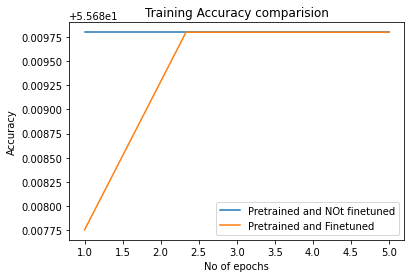

In [56]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(1,21,20)
plt.plot(x, train_accuray_model1, label = "Pretrained and NOt finetuned")
plt.plot(x, train_accuray_model2, label = "Pretrained and Finetuned")
plt.plot(x, train_accuray_model3, label = "Not Pretrained")
plt.xlabel('No of epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy comparision')
plt.legend()
plt.show()